In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import ParameterGrid
import xarray as xr
import xskillscore as xs
import numpy as np
import matplotlib.pyplot as plt

Functions

In [ ]:
#Function to rename the coordinates
def rename_lat_lon_time(dataset):
    #lat/lon
    if 'latitude' in dataset.coords or 'longitude' in dataset.coords:
        dataset = dataset.rename({"latitude": "lat", "longitude": "lon"})
    #time
    if 'valid_time' in dataset.coords:
        dataset = dataset.rename({"valid_time": "time"})
    #indexing_time --> time
    if 'indexing_time' in dataset.coords:
        dataset = dataset.rename({"indexing_time": "time"})
    #forecast_reference_time --> time
    if 'forecast_reference_time' in dataset.coords:
        dataset = dataset.rename({"forecast_reference_time": "time"})

    return dataset

In [ ]:
#Function to select just the hindcast members
def hindcast_ensemble(dataset,ensemble_number_hindcast):
    dataset_new = dataset[:ensemble_number_hindcast,:,:,:,:]
    return dataset_new

In [ ]:
#Same longitude and latitude as ERA5
def common_lon_lat_values(dataset):
    # Longitude = [-180, 179]
    dataset = dataset.assign_coords(lon=((dataset.lon + 180 - 0.5) % 360 - 180))
    # Ascending order
    dataset = dataset.sortby('lon')
    # Latitude = [90, -89]
    dataset = dataset.assign_coords(lat=dataset.lat + 0.5)
    return dataset

In [ ]:
#Function to obtain the specific month value of a variable for each year and to compute the climatology (1994-2016) and the anomaly for the specific month
def compute_obs_anomaly_monthly(string_variable,string_dic_yearly,string_dic_climatology,string_dic_anomaly,dataset,dictionary,name_months,i):
    dictionary[f'{name_months[i]} ({string_variable})'][string_dic_yearly] = dataset.sel(time=dataset['time.month'] == (i+1))
    #Compute the climatology of the ensemble
    dictionary[f'{name_months[i]} ({string_variable})'][string_dic_climatology] = dictionary[f'{name_months[i]} ({string_variable})'][string_dic_yearly].mean(dim=('time'))
    #Compute the anomaly of the single member and of each year
    dictionary[f'{name_months[i]} ({string_variable})'][string_dic_anomaly] = dictionary[f'{name_months[i]} ({string_variable})'][string_dic_yearly] - dictionary[f'{name_months[i]} ({string_variable})'][string_dic_climatology]

    dictionary[f'{name_months[i]} ({string_variable})'][string_dic_anomaly] = dictionary[f'{name_months[i]} ({string_variable})'][string_dic_anomaly].assign_coords(time=dictionary[f'{name_months[i]} ({string_variable})'][string_dic_anomaly].time.dt.year)
    return dictionary[f'{name_months[i]} ({string_variable})'][string_dic_anomaly], dictionary[f'{name_months[i]} ({string_variable})'][string_dic_climatology], dictionary[f'{name_months[i]} ({string_variable})'][string_dic_yearly]


In [ ]:
#Function to compute the yearly means of a dataset for a specific season
def compute_yearly_seasonal_mean(dataset,year_start,year_end,i):
    # Map season index to months
    season_months = {
        0: [1, 2],       # JF
        1: [3, 4, 5],    # MAM
        2: [6, 7, 8, 9], # JJAS
        3: [10, 11, 12]  # OND
    }
    
    dataset = dataset.sel(time=slice(year_start, year_end)) #Select the analysis' years    
    season_data = dataset.sel(time=dataset["time.month"].isin(season_months[i])) #Select the months for the specific season 
    dataset_mean_yearly = season_data.groupby("time.year").mean(dim="time") #ensemble mean for each year
    return dataset_mean_yearly

#Function to compute the anomaly, climatology and yearly sst for each season
def compute_obs_anomaly(string_variable,string_dic_yearly,string_dic_climatology,string_dic_anomaly,dataset,dataset_sa,dictionary,season,i):
    #Divide the dataset into the four seasons
    if season == ['JF','MAM','JJAS','OND']: #JF, MAM, JJAS, OND
        dictionary[f'{season[i]} ({string_variable})'][string_dic_yearly] = compute_yearly_seasonal_mean(dataset,"1994","2016",i)
        dictionary[f'{season[i]} ({string_variable})'][string_dic_yearly] = dictionary[f'{season[i]} ({string_variable})'][string_dic_yearly].rename({"year": "time"})
    
    #Compute the climatology of the ensemble
    dictionary[f'{season[i]} ({string_variable})'][string_dic_climatology] = dictionary[f'{season[i]} ({string_variable})'][string_dic_yearly].mean(dim=('time'))
    #Compute the anomaly of the single member and of each year
    dictionary[f'{season[i]} ({string_variable})'][string_dic_anomaly] = dictionary[f'{season[i]} ({string_variable})'][string_dic_yearly] - dictionary[f'{season[i]} ({string_variable})'][string_dic_climatology]

    return dictionary[f'{season[i]} ({string_variable})'][string_dic_anomaly], dictionary[f'{season[i]} ({string_variable})'][string_dic_climatology], dictionary[f'{season[i]} ({string_variable})'][string_dic_yearly]


In [ ]:
#Function to compute the season of a hindcasts data from C3S
def compute_season(dataset,year_start_string,year_end_string,month_start,forecastMonth_list):
    #Select the starting and ending years
    dataset = dataset.sel(time=slice(year_start_string,year_end_string))
    #Select the month when the run is initialized, select the season
    dataset_season = dataset.where(dataset["time.month"] == month_start, drop=True)
    #Select the months from when the run is initialized (forecast months)
    dataset_season = dataset_season.sel(forecastMonth=forecastMonth_list)
    #if the month_start is december the years of dataset_season will be shifted one year forward, otherwise there will be a confusion (Because with december as the start month, the season will be the JF of the following year)
    if month_start in [11,12]:
        new_times = [pd.Timestamp(t).replace(year=pd.Timestamp(t).year + 1, month=1, day=1) for t in dataset_season["time"].values]
        dataset_season = dataset_season.assign_coords({"time": ("time", new_times)})
    elif year_start_string == '1993' and month_start in [9, 10]:
        new_times = [pd.Timestamp(t).replace(year=pd.Timestamp(t).year + 1, month=1, day=1) for t in dataset_season["time"].values]
        dataset_season = dataset_season.assign_coords({"time": ("time", new_times)})
         
    #Group the single years and mean over forecastMonth to obtain the season
    dataset_season = dataset_season.groupby("time").mean("forecastMonth")

    return dataset_season

#Function to compute the seasonal value for each year of a variable at 3-months lead time, for OND season
def lead_time_3(dictionary_list,seasons,string_variable,dataset,month_start):
    dictionary_list[f'{seasons}, lead time 3 ({string_variable})'] = compute_season(dataset,'1994','2016',month_start,[4,5,6])   
    #Re-assign time coordinates
    dictionary_list[f'{seasons}, lead time 3 ({string_variable})'] = dictionary_list[f'{seasons}, lead time 3 ({string_variable})'].assign_coords(time=dictionary_list[f'{seasons}, lead time 3 ({string_variable})'].time.dt.year)

    return dictionary_list[f'{seasons}, lead time 3 ({string_variable})']

In [ ]:
#Function to select the indian ocean area spatial domain
def di_indian_ocean_area(dataset):
    di = dataset.sel(lon=slice(50,110),lat=slice(10,-10),time=slice('1993','2016'))
    return di

In [ ]:
#Function to select the spatial domain where to compute the Dipole Index
def di_west_east(dataset):
    di_west = dataset.sel(lon=slice(50,70),lat=slice(10,-10),time=slice('1993','2016')).mean(dim=('lon','lat'))
    di_east = dataset.sel(lon=slice(90,110),lat=slice(0,-10),time=slice('1993','2016')).mean(dim=('lon','lat'))
    return di_west, di_east

Variable definition

In [ ]:
name_months = ['JUL','AUG','SEP','OCT'] #Run's initialization's months. The chosen month for this analysis is JUL
seasons = ['JF','MAM','JJAS','OND'] #Name of the possible seasons. The chosen season for this analysis is OND
number_lead_time = 4 #0,1,2,3 possible lead time

Upload ERA5 dataset, conservatively remapped

In [ ]:
era5_sst_remapcon = xr.open_dataset(r"/mnt/c/Users/project/era5_sst/era5_sst_remapcon.nc") #Upload ERA5 dataset
era5_sst_remapcon = rename_lat_lon_time(era5_sst_remapcon['sst']) #Rename the 'lon', 'lat', 'time' coordinates
era5_sst_remapcon = era5_sst_remapcon.sel(time=slice('1994','2016')) #Select the years
era5_sst_remapcon_indian_ocean = di_indian_ocean_area(era5_sst_remapcon) #Select the indian ocean area spatial domain

Upload HadISST dataset

In [ ]:
hadisst_remapcon = xr.open_dataset(r"/mnt/c/Users/project/HadISST_sst.nc") ##Upload HadISST dataset
hadisst_remapcon = rename_lat_lon_time(hadisst_remapcon['sst']) #Rename the 'lon', 'lat', 'time' coordinates
hadisst_remapcon = hadisst_remapcon.sel(time=slice('1994','2016')) #Select the years
hadisst_remapcon = hadisst_remapcon.assign_coords(lat = hadisst_remapcon.lat + 0.5,lon = hadisst_remapcon.lon - 0.5) #New values for longitude and latitude
hadisst_remapcon = hadisst_remapcon.where(hadisst_remapcon >= -600, np.nan)
hadisst_remapcon_indian_ocean = di_indian_ocean_area(hadisst_remapcon) #Select the indian ocean area spatial domain

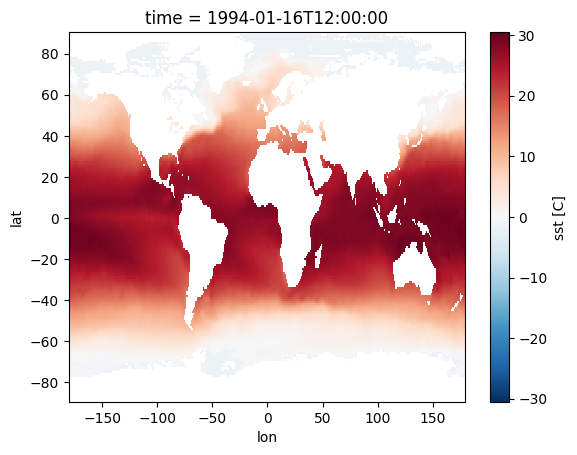

In [ ]:
hadisst_remapcon.isel(time=0).plot()

Upload ECMWF dataset

In [ ]:
ecmwf_sst = xr.open_dataset(r"/mnt/c/Users/project/ecmwf_sst.nc") #Upload ECMWF dataset
ecmwf_sst = rename_lat_lon_time(ecmwf_sst['sst']) #Rename the 'lon', 'lat', 'time' coordinates
ecmwf_sst = hindcast_ensemble(ecmwf_sst,25) #Select the hindcast's members
ecmwf_sst = common_lon_lat_values(ecmwf_sst) #Re-assign longitude/latitude coordinates in order to have the same as ERA5

Compute climatology and anomalies for ERA5 and HadISST datasets

In [ ]:
#ERA5 and HadISST dictionary
era5_dic = {}
hadisst_dic = {}

In [ ]:
#Compute the anomaly adn the climatology over the indian ocean area
for i in range(len(name_months)): 
    era5_dic[f'{name_months[i]} (di west-est)'] = {} # (di west-east) stands as a reference of the Dipole Index computation
    era5_dic[f'{name_months[i]} (di west-est)']['anomaly indian ocean area'], era5_dic[f'{name_months[i]} (di west-est)']['climatology indian ocean area'], era5_dic[f'{name_months[i]} (di west-est)']['yearly sst indian ocean area'] = compute_obs_anomaly_monthly('di west-est','yearly sst indian ocean area','climatology indian ocean area','anomaly indian ocean area',era5_sst_remapcon_indian_ocean,era5_dic,name_months,i)
 
    hadisst_dic[f'{name_months[i]} (di west-est)'] = {}
    hadisst_dic[f'{name_months[i]} (di west-est)']['anomaly indian ocean area'], hadisst_dic[f'{name_months[i]} (di west-est)']['climatology indian ocean area'], hadisst_dic[f'{name_months[i]} (di west-est)']['yearly sst indian ocean area'] = compute_obs_anomaly_monthly('di west-est','yearly sst indian ocean area','climatology indian ocean area','anomaly indian ocean area',hadisst_remapcon_indian_ocean,hadisst_dic,name_months,i)

Compute the OND Dipole Index for ERA5

In [ ]:
era5_sst_di = di_west_east(era5_sst_remapcon) #2 elements: west,east. #Select the spatial domain to compute the Dipole index
era5_dic['OND (di west-east)']['anomaly'], era5_dic['OND (di west-east)']['climatology'], era5_dic['OND (di west-east)']['yearly precipitation'] = compute_obs_anomaly('di west-east','yearly sst','climatology','anomaly',era5_sst_di[0]-era5_sst_di[1],era5_sst_di[0]-era5_sst_di[1],era5_dic,seasons,3) #3 is the index for OND month
#Compute the Dipole Index
era5_dic['OND (di west-east)']['dipole index'] = era5_dic['OND (di west-east)']['anomaly'] / era5_dic['OND (di west-east)']['yearly sst'].std(dim='time')

Compute the OND at 3 months lead time Dipole Index for ECMWF

In [ ]:
ecmwf_sst_di = di_west_east(ecmwf_sst) #2 elements: west,east. Select the spatial domain to compute the Dipole index

In [ ]:
ecmwf_dic = {} #ECMWF dictionary
ecmwf_dic['OND, lead time 3 (di west-east)'] = {}
ecmwf_dic['OND, lead time 3 (di west-east)'] = lead_time_3(ecmwf_dic,seasons[3],'di west-east',ecmwf_sst_di[0]-ecmwf_sst_di[1],7)

In [ ]:
#Compute the climatology for the multi-model mean
ecmwf_dic['OND, lead time 3 (di west-east)']['climatology ensemble'] = ecmwf_dic['OND, lead time 3 (di west-east)'].mean(dim=('number','time'))
#Compute the anomaly of the single member and of each year
ecmwf_dic['OND, lead time 3 (di west-east)']['anomaly'] = ecmwf_dic['OND, lead time 3 (di west-east)'] - ecmwf_dic['OND, lead time 3 (di west-east)']['climatology ensemble']
#Compute the Dipole index
ecmwf_dic['OND, lead time 3 (di west-east)']['dipole index'] = ecmwf_dic['OND, lead time 3 (di west-east)']['anomaly'] / ecmwf_dic['OND, lead time 3 (di west-east)'].std(dim=('time','number'))

Implementation of the CNN

In [ ]:
# ---------------------------
# 1. Define parameter grid
# ---------------------------

grid_search_params = {
    'filter_size': [(3,3), (5,5)],
    'initial_filters': [8, 16, 32],
    'initial_dropout': [0, 0.1, 0.2, 0.3],
    'dense_units': [50, 100, 150],
    'batch_size': [8, 16, 32, 64],
    'learning_rate': [0.1, 0.01, 0.001]
}

param_grid = list(ParameterGrid(grid_search_params))

In [ ]:
# ---------------------------
# 3. Training and validation data
# ---------------------------

#Training
#Obs: the NaN values, which stands for the land domain, are replaced with null values
#Dims: (time,lat,lon,channels where channels stands for the number of input, that is 1
X_train = era5_dic['JUL (di west-est)']['anomaly indian ocean area'].fillna(0).expand_dims(dim='channels').transpose('time', 'lat', 'lon', 'channels') #Anomaly of the indian ocean spatial domain for the July month from ERA5
#Dims: (time,)
y_train = ecmwf_dic['OND, lead time 3 (di west-east)']['dipole index'].mean(dim='number') #Dipole Index for the OND season at lead time of 3 months from ECMWF, averaged over all members

#Validation
#Dims: (time,lat,lon,channels where channels stands for the number of input, that is 1
X_val = hadisst_dic['JUL (di west-est)']['anomaly indian ocean area'].fillna(0).expand_dims(dim='channels').transpose('time', 'lat', 'lon', 'channels')  # (23, 21, 61, 1)
#Dims: (time,)
y_val = era5_dic['OND (di west-east)']['dipole index'] #Dipole Index for the OND season

In [ ]:
# ---------------------------
# 2. Lists for top models
# ---------------------------

top_models = []
top_scores = []

In [ ]:
# ---------------------------
# 4. Loop over all parameter combinations
# ---------------------------

for params in param_grid:
    print(f"Training with params: {params}")

    # Build model
    model = models.Sequential()

    filters = params['initial_filters']
    dropout = params['initial_dropout']

    # First Conv Block
    model.add(layers.Conv2D(filters=filters, kernel_size=params['filter_size'], activation='elu', input_shape=X_train.shape[1:], padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(dropout))

    # Second Conv Block
    filters *= 2
    dropout += 0.1
    model.add(layers.Conv2D(filters=filters, kernel_size=params['filter_size'], activation='elu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(dropout))

    # Third Conv Block
    filters *= 2
    dropout += 0.1
    model.add(layers.Conv2D(filters=filters, kernel_size=params['filter_size'], activation='elu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(dropout))

    model.add(layers.Flatten())
    model.add(layers.Dense(params['dense_units'], activation='elu'))
    model.add(layers.Dense(1))  # Output layer

    # Optimizer with initial learning rate
    optimizer = optimizers.Adam(learning_rate=params['learning_rate'])

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # Learning rate scheduler
    lr_scheduler = callbacks.ReduceLROnPlateau(factor=0.5, patience=10, verbose=1)

    # Early stopping for faster tuning
    early_stop = callbacks.EarlyStopping(patience=10, restore_best_weights=True)

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=params['batch_size'],
        callbacks=[lr_scheduler, early_stop],
        verbose=0
    )

    # Evaluate on validation set
    val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)

    # Save top 10 models
    if len(top_models) < 10:
        top_models.append(model)
        top_scores.append(val_loss)
    else:
        max_loss_idx = np.argmax(top_scores)
        if val_loss < top_scores[max_loss_idx]:
            top_models[max_loss_idx] = model
            top_scores[max_loss_idx] = val_loss

In [ ]:
# ---------------------------
# 5. Ensemble average of top 10 models
# ---------------------------

# Make predictions with each model and compute average
predictions = [m.predict(X_val) for m in top_models]
ensemble_prediction = np.mean(predictions, axis=0)


In [ ]:
plt.figure(figsize=(10,5))
plt.plot(y_val.time, y_val, color='black',label='Observed ERA5', marker='o')
plt.plot(y_val.time, ensemble_prediction, label='Predicted CNN at lead time 3 months', marker='x')
plt.xlabel('years')
plt.ylabel('Dipole Index')
plt.title(f'True vs Ensemble Prediction with ACC = {np.round(xs.pearson_r(y_val,ensemble_prediction,dim='time'),3).values}') #Compute the correlation between observed ERA5 and CNN's prediction
plt.legend()
plt.show()